# Data Science Minneapolis: Intro to TensorFlow 2

By Yaniv Ben-Ami, Ph.D

## About me

* Yale Ph.D in Economics 
* Assistant Professor of Economics at Carleton College
* Teaching Macroeconomics, Finance and Econometrics


* Passion: A recent Deep Learning convert after reading [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by Francois Chollet
* Meetup: I lead the [Twin Cities Deep Learning Study Group](https://www.meetup.com/Twin-Cities-Deep-Learning-Study-Group/) every Sunday at 2 pm
* Consulting: [EasyAsPie.ai](http://easyaspie.ai)
* LinkedIn: Feel free to [connect](https://www.linkedin.com/in/yaniv-ben-ami-9208b9184/)

## Other projects
* Variational Auto-Encoders for Costumer Insight ([notebook](https://github.com/yaniv256/VAEs-in-Economics/blob/master/Notebooks/One_Dimensional_VAE_Workshop.ipynb), [blog](https://www.linkedin.com/pulse/variational-auto-encoders-customer-insight-yaniv-ben-ami/))
* Variational Auto-Encoders for U.S. Covid-19 County-level data ([notebook](https://github.com/yaniv256/VAEs-in-Economics/blob/master/Notebooks/Covid_19_VAEs_counties.ipynb), [video](https://www.youtube.com/watch?v=Ua5KwXaRB2E))
* Next project: create training for the [TensorFlow Developer Certificate](https://www.tensorflow.org/certificate)

## This workshop

1. The three APIs of TensorFlow 2
2. Airbnb price regressions
3. Not a black box: deep learning insights from gradients

## How to run the notebook?

* The Jupyter Notebook is available at https://github.com/yaniv256/workshops/blob/master/notebooks/TF2-intro-Airbnb.ipynb
* To run it on Google Colab: 
    * Web search Colab
    * Go to the `Github` tab 
    * Enter `yaniv256`
    * Pick the `workshops` repository
    * Click `TF2-intro-Airbnb.ipynb`
* The slides are produced as a live view on the Jupyter Notebook using the fabulous [Rise](https://rise.readthedocs.io/en/stable/) extension

## Why TensorFlow 2?

TF2: "We will add your biological and technological distinctiveness to our own... Resistance is futile."
* Freely copied the best of PyTorch
* Keras was assimilated
* TF2 is still more popular (according to [Google trends](https://trends.google.com/trends/explore?date=today%205-y&geo=US&q=TensorFlow,PyTorch,Keras))

![](https://upload.wikimedia.org/wikipedia/en/a/a1/Picard_as_Locutus.jpg)

## Resources
* This talk is based on chapter 10, 11 and 12 of 
[Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
![](https://images-na.ssl-images-amazon.com/images/I/51aqYc1QyrL._SX379_BO1,204,203,200_.jpg)

* Opinions are my own
* Insights from Gradients are my own

## The three APIs

1. Sequential: when all you need is a stack of layers
2. Functional: when you want to connect layers in whatever way
3. Subclassing: Object Oriented + connect on input

And there's also TensorFlow itself - good for any symbolic computation.

### Example: Sequential API

In [44]:
import tensorflow.keras as keras

def build_model_sequential(input_shape, activation='relu', width=128):

    model = keras.Sequential()
    model.add(keras.layers.Dense(width, activation=activation,
                                 input_shape=input_shape))
    model.add(keras.layers.Dense(width, activation=activation))
    model.add(keras.layers.Dense(1))

    return model

model = build_model_sequential((15,))
print(model)

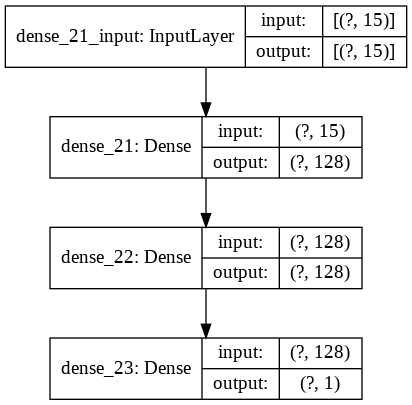

In [45]:
keras.utils.plot_model(model, show_shapes=True)

### Example: Functional API

In [46]:
import tensorflow.keras as keras

def build_model_functional(input_shape, activation='relu', width=128):

    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Dense(width, activation=activation)(inputs)
    x = keras.layers.Dense(width, activation=activation)(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

model = build_model_functional((15,))
print(model)

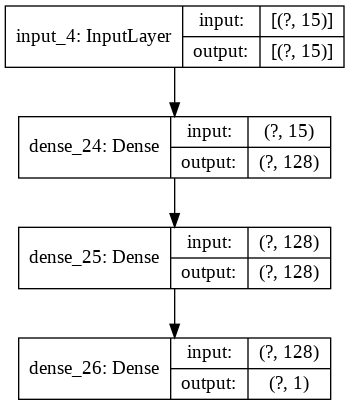

In [47]:
keras.utils.plot_model(model, show_shapes=True)

### Example: Subclassing API

In [48]:
def build_model_subclassing(activation='relu', width=128):

    class MyModel(keras.Model):
        def __init__(self):
            super(MyModel, self).__init__()
            self.dense1 = keras.layers.Dense(width, activation=activation)
            self.dense2 = keras.layers.Dense(width, activation=activation)
            self.out = keras.layers.Dense(1)

        def call(self, x):
            x = self.dense1(x)
            x = self.dense2(x)
            return self.out(x)

    model = MyModel()

    return model

model = build_model_subclassing()
print(model)

<__main__.build_model_subclassing.<locals>.MyModel object at 0x7f4ef3a6fe80>


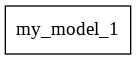

In [49]:
keras.utils.plot_model(model, show_shapes=True)

### Which API should you learn?

* Sequential is good enough for most tasks
* Same code in Functional is just as short and as clear

* If you want to build reusable objects, go for Subclassing
* Otherwise, Functional is as powerful

## Airbnb price regressions

* Predict a listings price based on its features
* Estimate listing value (find bargains)
* Estimate location value

## Valuation vs. prediction

* Making a best prediction isn't the same as estimating value
* Many listings are overpriced
* Lots of reviews indicate price is low relative to listing value

## Highlight: Insight from gradients

* What is the sensitivity of a prediction to each input?
* Which variables are most important?
* How to examine non-linearities and interactions?

Answers to all: gradients.

# InsideAirbnb data

Data source: http://insideairbnb.com/index.html

* Local interest everywhere
* Up to date
* Time series, images, NLP (not today, though)

## Load Twin Cities data

In [50]:
%%writefile airbnbloader.py
from collections import OrderedDict
import pandas as pd
from datetime import datetime
import numpy as np


def load(date='2020-10-24', location='united-states/mn/twin-cities-msa'):

    filename = (
        'http://data.insideairbnb.com/{}/{}/data/listings.csv.gz'.format(
            location, date))

    data = pd.read_csv(filename)

    data.price = data.price.apply(lambda x: float(x[1:].replace(',', '')))

    weekday = data.last_review.dropna().apply(
      lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%A'))
    weekday.name = 'last_review_weekday'
    data = data.join(weekday)

    days_since_last_review = data.last_review.dropna().apply(
        lambda x: (datetime.strptime(date, '%Y-%m-%d')
                   - datetime.strptime(x, '%Y-%m-%d')).days)
    days_since_last_review.name = 'days_since_last_review'
    data = data.join(days_since_last_review)

    features = data[[
        'price',
        'latitude',
        'longitude',
        'room_type',
        'accommodates',
        'bathrooms',
        'bedrooms',
        'beds',
        'minimum_nights',
        'days_since_last_review',
        'number_of_reviews',
        'reviews_per_month',
        'calculated_host_listings_count',
        'availability_30',
        'availability_365'
        ]]

    features.dropna(inplace=True)
    features = features[features.availability_365 != 0]
    features = features[features.availability_365 != 365]

    onehot_room_type = pd.get_dummies(features['room_type'])

    onehot_room_type.drop(['Private room'], axis=1, inplace=True)

    features = pd.concat([features, onehot_room_type], axis=1)

    targets = features['price'].apply(lambda x: np.log(x+1))

    features.drop(['price', 'room_type'], axis=1, inplace=True)

    return features, targets, data


def all_value_counts(data, n=5):

    return OrderedDict(
        (field,
         dict(n=len(set(data[field])),
              top=list(zip(
                  data[field].value_counts().head(n).index,
                  data[field].value_counts().head(n).values))))
        for field in data.columns)

Overwriting airbnbloader.py


Some dates that are available for `location='united-states/mn/twin-cities-msa':`
* Last May: date='2019-05-05'
* Last January: date='2020-01-04'
* Most recent: date='2020-05-12'

In [51]:
import importlib
import warnings
import airbnbloader

warnings.filterwarnings('ignore')

features, targets, data = airbnbloader.load(
    location='united-states/mn/twin-cities-msa',
    date='2020-05-12'
)

features.shape, targets.shape, data.shape

((2885, 16), (2885,), (6617, 108))

In [52]:
features.head()

latitude  longitude  accommodates  ...  Entire home/apt  Hotel room  Shared room
0  45.00886  -93.23407             5  ...                1           0            0
1  44.94566  -93.35721             5  ...                0           0            0
2  44.91878  -93.23038             3  ...                0           0            0
3  44.91985  -93.35141             3  ...                1           0            0
4  44.94800  -93.19037             4  ...                1           0            0

[5 rows x 16 columns]

Split to train and test data sets.

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,
    targets,
    test_size=0.25,
    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2163, 16), (722, 16), (2163,), (722,))

## Map listings

In [54]:
%%writefile mapairbnb.py
import plotly.graph_objects as go


def plot(data, features, color_by, color_title, estimate=None, zoom=10,
         hover=True, center=dict(lat=44.981944, lon=-93.269167)):

    data_ = data.loc[features.index]

    if hover:
        text = [
            '{}  <br>Price: ${:.0f}'.format(data_.name[i], data_.price[i])
            + (' Estimated: ${:.0f}'.format(estimate[i]) 
               if estimate is not None else '')
            + '<br>Number of reviews: {}<br>'.format(
                data_.number_of_reviews[i])
            + ' <a href="{}">link</a>'.format(
                data_.listing_url[i])
            + '<br>Availability: {}'.format(data_.availability_365[i])
            + '<br>Days since last review: {}'.format(
                features.days_since_last_review[i])
            + '<br>Accommodates: {}'.format(features.accommodates[i])
            for i in data_.index]
    else:
        text = ''

    fig = go.Figure(go.Scattermapbox(
        lat=features.latitude,
        lon=features.longitude,
        mode='markers',
        text=text,
        hoverinfo='text',
        marker=dict(color=color_by, colorscale='rainbow',
                    colorbar=dict(title=color_title), size=9),
        ))

    fig.update_layout(
        hovermode='x',
        hoverdistance=20,
        mapbox_style='white-bg',
        autosize=False,
        width=900,
        height=400,
        mapbox_layers=[{
            'below': 'traces', 'sourcetype': 'raster',
            'source': ['https://basemap.nationalmap.gov/arcgis/rest/services/'
                       + 'USGSImageryOnly/MapServer/tile/{z}/{y}/{x}']}],
        mapbox=dict(bearing=0, center=center, pitch=0, zoom=zoom),
        )

    fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

    return fig

Overwriting mapairbnb.py


In [55]:
import mapairbnb

mapairbnb.plot(data, features, color_by=targets, color_title='Log price')

# OLS Regression
Let's run an OLS regression as a benchmark

In [56]:
import statsmodels.api as sm
import pandas as pd

X_train_with_const = sm.add_constant(
    pd.DataFrame(X_train, columns=features.columns))
X_test_with_const = sm.add_constant(
    pd.DataFrame(X_test, columns=features.columns))

results = sm.OLS(y_train, X_train_with_const).fit(cov_type='HC0')

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     247.2
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:50:44   Log-Likelihood:                -1691.5
No. Observations:                2163   AIC:                             3417.
Df Residuals:                    2146   BIC:                             3514.
Df Model:                          16                                         
Covariance Type:                  HC0                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

## Estimate value

* Lots of reviews indicate lower prices relative to listing value
* We need to fix the review variables on some constant
* Let's use the median

In [57]:
%%writefile fixcolumns.py
import numpy as np
import pandas as pd


def fix(data, fix_columns, fix_on):

    all_fixed = pd.DataFrame(
        np.tile(fix_on, (len(data), 1)),
        columns=data.columns)

    all_fixed.index = data.index

    fixed_data = data.copy()

    fixed_data[fix_columns] = all_fixed[fix_columns]

    return fixed_data


Overwriting fixcolumns.py


In [58]:
import fixcolumns

fix_reviews = fixcolumns.fix(
    data=features,
    fix_columns=[
        'days_since_last_review',
        'number_of_reviews',
        'reviews_per_month'],
    fix_on=features.median().values
    )

fix_reviews.head()

latitude  longitude  accommodates  ...  Entire home/apt  Hotel room  Shared room
0  45.00886  -93.23407             5  ...                1           0            0
1  44.94566  -93.35721             5  ...                0           0            0
2  44.91878  -93.23038             3  ...                0           0            0
3  44.91985  -93.35141             3  ...                1           0            0
4  44.94800  -93.19037             4  ...                1           0            0

[5 rows x 16 columns]

Now we can use the review-constant listings to estimate the "right" price for listings and compare that to what it is listed for. 

In [59]:
import numpy as np

ols_predicted = results.predict(
    sm.add_constant(fix_reviews, has_constant='add'))
overpriced = targets-ols_predicted

importlib.reload(mapairbnb)

mapairbnb.plot(
    data, features, color_by=overpriced, estimate=ols_predicted.apply(np.exp), 
    color_title='Diff log price')

## Location, location, location!

* To see the effect of location we need to hold everything else fixed. 

In [60]:
location_only = fixcolumns.fix(
    data=features,
    fix_columns=features.columns[2:],
    fix_on=features.median().values
    )

location_only.head()

latitude  longitude  accommodates  ...  Entire home/apt  Hotel room  Shared room
0  45.00886  -93.23407           4.0  ...              1.0         0.0          0.0
1  44.94566  -93.35721           4.0  ...              1.0         0.0          0.0
2  44.91878  -93.23038           4.0  ...              1.0         0.0          0.0
3  44.91985  -93.35141           4.0  ...              1.0         0.0          0.0
4  44.94800  -93.19037           4.0  ...              1.0         0.0          0.0

[5 rows x 16 columns]

Fixing all but location we can map the value of a location.

In [61]:
import numpy as np

location_predicted = results.predict(
    sm.add_constant(location_only, has_constant='add'))

mapairbnb.plot(data, features, color_by=np.exp(location_predicted),
               color_title='Predicted price', zoom=7, hover=False)

This clearly fails. A linear model can only generate linear maps, but location isn't linear.

# TensorFlow 2
* Coding in TensorFlow is very similar to coding with NumPy 
* Just use TensorFlow functions
* Unlike NumPy, TensorFlow keeps track of derivatives

## Adding a custom metric: $R^2$


To get a feel for pure TensorFlow let's write a TensorFlow function calculating $R^2$. Recall that 

$$R^2=1-\frac{\Sigma (y-\hat{y})^2}{\Sigma (y-\bar{y})^2}$$

TensorFlow doesn't provide an $R^2$ metric, most likely because

1. $R^2$ computed on each batch is a downward biased estimate of whole epoch $R^2$
2. Average batch $R^2$ will not equal whole epoch $R^2$

We will use the usual small sample bias correction

$$\tilde{R}^2=1-\frac{\Sigma (y-\hat{y})^2}{\frac{n}{n-1}\Sigma (y-\bar{y})^2}$$

In [62]:
%%writefile tf_r2.py
import tensorflow as tf

def R_squared(y_true, y_pred):

    # TensorFlow uses 'float32' as the default type and often raises an error
    # when you mix 'float32' and 'float64' in calculations. Casting everything
    # to 'float32' is your best option.
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')

    residual_var = tf.reduce_sum(tf.square(y_true - y_pred))
    total_var = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))

    # Adjust for small batch bias
    n = tf.cast(tf.size(y_true), 'float32')
    total_var *= n/(n-1)

    return (1.0 - residual_var/total_var)

Overwriting tf_r2.py


Tensorflow functions produce tensors which are only computed when you call `.numpy()` on them.

In [63]:
import numpy as np
import tf_r2

OLS_r2 = dict(
    Train=tf_r2.R_squared(
        y_train,
        results.predict(X_train_with_const)
        ).numpy(),
    Test=tf_r2.R_squared(
        y_test,
        results.predict(X_test_with_const)
        ).numpy()
    )

pd.DataFrame(pd.Series(OLS_r2), columns=['OLS R2']).transpose()

Train     Test
OLS R2  0.629655  0.59767

## Add dropout
* Add dropout regularization layers. 
* In each of the three APIs:

In [64]:
%%writefile simple_dnn.py

import tensorflow.keras as keras

# The sequencial API: create one layer at a time and add it to the model. We 
# don't have to provide the shape of the input, but if we don't the 
# construction of the model will be delayed until the first call to `fit()`


def build_model_sequential(
        input_shape=None,
        dropout=0.2,
        activation='relu',
        width=128,
        n_hidden=2):

    model = keras.Sequential()
    for i in range(n_hidden):
        if i == 0 and input_shape:
            model.add(keras.layers.Dense(width,
                                         activation=activation,
                                         input_shape=input_shape))
        else:
            model.add(keras.layers.Dense(width, activation=activation))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1))

    return model

# The functional API: create layers and apply them, all before input. We have
# to provide the shape of the input to `keras.Input`.


def build_model_functional(
        input_shape,
        dropout=0.2,
        activation='relu',
        width=128,
        n_hidden=2):

    inputs = keras.Input(shape=input_shape)
    x = inputs
    for i in range(n_hidden):
        x = keras.layers.Dense(width, activation=activation)(x)
        x = keras.layers.Dropout(dropout)(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

# The subclassing API: create layers and store them, apply only on input. We 
# don't need to provide the shape of the input.


def build_model_subclassing(
        dropout=0.2,
        activation='relu',
        width=128,
        n_hidden=2):

    class MyModel(keras.Model):
        def __init__(self):
            super(MyModel, self).__init__()
            self.dense = []
            self.dropout = []
            for i in range(n_hidden):
                self.dense.append(
                    keras.layers.Dense(
                        width, activation=activation))
                self.dropout.append(keras.layers.Dropout(dropout))
            self.out = keras.layers.Dense(1)

        def call(self, x):
            for i in range(n_hidden):
                x = self.dense[i](x)
                x = self.dropout[i](x)
            return self.out(x)

    model = MyModel()

    return model

Overwriting simple_dnn.py


You can't ask for `summary()` when not providing input_shape as the layers only 
get built on the first input.

In [65]:
import simple_dnn

simple_dnn.build_model_sequential(X_train.shape[1:]).summary()

# This will work:
# simple_dnn.build_model_functional(X_train.shape[1:]).summary()

# This will not:
# keras_dnn.build_model_sequential().summary()
# keras_dnn.build_model_subclassing().summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               2176      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 129       
Total params: 18,817
Trainable params: 18,817
Non-trainable params: 0
_________________________________________________________________


## Standard scale the features
* Neural networks perform much better on scaled inputs

In [66]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('X_train mean\t{:.2e}\tX_test mean\t{:.4f}'.format(
    X_train_scaled.mean(), X_test_scaled.mean()))

print('X_train std \t{:.4f}   \tX_test std \t{:.4f}'.format(
    X_train_scaled.std(), X_test_scaled.std()))

X_train mean	-7.96e-16	X_test mean	-0.0115
X_train std 	1.0000   	X_test std 	1.0488


## Training 
Training has the same interface for all APIs. Here we'll
* Minimize Mean Square Error (MSE) using Stochastic Gradient Decent
* Keep track of $R^2$
* Use only full batchs ($R^2$ needs this)
* Stop after no improvement on validation for 30 epochs
* Get back to best performing model at the end

In [67]:
%%writefile train_dnn.py

import tensorflow.keras as keras
from tf_r2 import R_squared

def train(model, X_train, y_train, X_test, y_test, 
          optimizer=keras.optimizers.SGD(0.025),
          batch_size = 32, epochs=1000, patience=30):
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=[R_squared])

    X_train = X_train[:-(len(X_train) % batch_size)]
    y_train = y_train[:-(len(y_train) % batch_size)]
    X_test = X_test[:-(len(X_test) % batch_size)]
    y_test = y_test[:-(len(y_test) % batch_size)]

    early_stopping = keras.callbacks.EarlyStopping(
        patience=patience,
        restore_best_weights=True)

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )

    return history


Overwriting train_dnn.py


In [68]:
import train_dnn
import tensorflow as tf

tf.random.set_seed(42)

# You can pick any of the following
# model = simple_dnn.build_model_sequential()
# model = simple_dnn.build_model_sequential(X_train.shape[1:])
model = simple_dnn.build_model_functional(X_train.shape[1:])
# model = simple_dnn.build_model_subclassing()

history = train_dnn.train(model, X_train_scaled, y_train,
                          X_test_scaled, y_test)

Epoch 1/1000
67/67 [==============================] - 0s 3ms/step - loss: 1.7119 - R_squared: -1.3242 - val_loss: 0.4168 - val_R_squared: 0.3550
Epoch 2/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.5772 - R_squared: 0.1807 - val_loss: 0.3387 - val_R_squared: 0.4751
Epoch 3/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.4888 - R_squared: 0.3068 - val_loss: 0.3031 - val_R_squared: 0.5399
Epoch 4/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.4290 - R_squared: 0.3915 - val_loss: 0.3451 - val_R_squared: 0.4750
Epoch 5/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.3902 - R_squared: 0.4769 - val_loss: 0.2840 - val_R_squared: 0.5684
Epoch 6/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.3601 - R_squared: 0.5029 - val_loss: 0.2598 - val_R_squared: 0.6067
Epoch 7/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.3542 - R_squared: 0.5038 - val_loss: 0.2635 - val_R_squared

## Performance

In [69]:
import tf_r2

DNN_r2 = dict(
    Train=tf_r2.R_squared(
        y_train, model.predict(X_train_scaled).flatten()
        ).numpy(),
    Test=tf_r2.R_squared(
        y_test, model.predict(X_test_scaled).flatten()
        ).numpy()
    )

pd.DataFrame([OLS_r2, DNN_r2], index=['OLS R2', 'DNN R2'])

Train     Test
OLS R2  0.629655  0.59767
DNN R2  0.770162  0.67242

## Estimate value

In [70]:
dnn_predicted = model.predict(scaler.transform(fix_reviews)).flatten()
dnn_predicted = pd.Series(dnn_predicted, index = features.index, name='Estimate')
overpriced = targets-dnn_predicted
mapairbnb.plot(data, features, color_by=overpriced, estimate=dnn_predicted.apply(np.exp),
               color_title='Diff log price')

## Location, location, location, again!



In [71]:
location_predicted = model.predict(scaler.transform(location_only)).flatten()

mapairbnb.plot(data, features, color_by=np.exp(location_predicted),
               color_title='Predicted price', zoom=8, hover=False)

Still a failure but at least it's not linear anymore.

# Insight from gradients

Real easy to compute derivatives in TF2
* Define inputs as TF variables
* Do TF calculations under a `with tf.GradientTape() as tape:`
* Call `tape.gradient(outputs, inputs)`

Note use of `model()` instead of `model.predict()`

In [72]:
import tensorflow as tf

X = tf.Variable(features.values, dtype='float32')

with tf.GradientTape() as tape:
    X_std = (X-scaler.mean_) / scaler.scale_
    predictions = model(X_std)   # model.predict() is for non-TF inputs

dnn_coefs = tape.gradient(predictions, X).numpy()

dnn_coefs = pd.DataFrame(dnn_coefs,
                         columns=features.columns,
                         index=features.index)
dnn_coefs.head()

latitude  longitude  accommodates  ...  Entire home/apt  Hotel room  Shared room
0 -0.107366   0.149603      0.013204  ...         0.852593   -2.166211    -0.593368
1 -0.298629   0.206393      0.091371  ...         0.173990   -1.081570    -0.742633
2 -0.004447   0.147224      0.041625  ...         0.192835   -0.543615    -0.093470
3  0.666566   0.505969      0.108071  ...         1.039226   -4.158352    -0.405603
4 -0.366193   0.299352      0.058190  ...         0.842831   -2.980941    -0.191957

[5 rows x 16 columns]

## Compare with OLS
* Coefficients are different for every observation 
* Avarage is still comparable to OLS

In [73]:
ols_coef = pd.Series(results.params[1::], name='OLS_coef')
dnn_mean_coef = pd.Series(dnn_coefs.mean(axis=0),
                          index=features.columns,
                          name='DNN_mean_grad')
pd.DataFrame([ols_coef, dnn_mean_coef]).transpose()

OLS_coef  DNN_mean_grad
latitude                        0.013644       0.067852
longitude                       0.165866       0.138202
accommodates                    0.054204       0.058793
bathrooms                       0.187950       0.184797
bedrooms                        0.085331       0.040920
beds                            0.000522       0.030863
minimum_nights                 -0.005671      -0.012054
days_since_last_review          0.000826       0.000727
number_of_reviews              -0.000035      -0.000265
reviews_per_month              -0.050405      -0.088642
calculated_host_listings_count -0.002179       0.001137
availability_30                 0.008134       0.003828
availability_365                0.000185       0.000175
Entire home/apt                 0.695733       0.614609
Hotel room                      0.818522      -1.571839
Shared room                     0.149730      -0.687852

## Variable Importance
For each observation we can estimate the importance of each variable by multiplying the coefficients by the deviation of inputs from their mean.

In [74]:
abs_effect = (dnn_coefs * (features-features.mean())).abs()

# Compute per-row sum and reshape it to a vertical vector
abs_effect_sum = np.reshape(abs_effect.sum(axis=1).values, (len(features), 1))

# Divide by the sum so that effects sum to 1
per_obs_importance = abs_effect / abs_effect_sum

per_obs_importance.head()

latitude  longitude  accommodates  ...  Entire home/apt  Hotel room  Shared room
0  0.003211   0.004344      0.001163  ...         0.357682    0.011347     0.003956
1  0.024185   0.041150      0.011452  ...         0.236234    0.008061     0.007044
2  0.000751   0.009032      0.199113  ...         0.330984    0.005122     0.001121
3  0.033279   0.036140      0.155333  ...         0.235622    0.011772     0.001461
4  0.010235   0.013876      0.038934  ...         0.184008    0.008126     0.000666

[5 rows x 16 columns]

Averaging across observations we have a measure of overall variable importance.

In [75]:
mean_abs_effect = per_obs_importance.mean().sort_values(ascending=False)

pd.DataFrame(
    mean_abs_effect/mean_abs_effect.sum(),
    columns=['Variable Importance'])

Variable Importance
Entire home/apt                            0.207443
accommodates                               0.127154
bathrooms                                  0.097673
reviews_per_month                          0.086238
days_since_last_review                     0.066367
bedrooms                                   0.063478
availability_30                            0.058407
calculated_host_listings_count             0.051683
beds                                       0.047330
number_of_reviews                          0.043322
availability_365                           0.042546
latitude                                   0.038386
longitude                                  0.032087
minimum_nights                             0.025824
Hotel room                                 0.008006
Shared room                                0.004056

## Explore non-linearity
* Plot coefficients on own variable value

In [76]:
%%writefile plotcoefs.py
import matplotlib.pyplot as plt
import matplotlib


def plot_coefs_by_self(features, coefs, ols_results):
    
    matplotlib.rcParams.update({'font.size': 16})
    plt.style.use('seaborn-whitegrid')

    for i, field in enumerate(features.columns):
        
        plt.figure(figsize=(10, 6))

        plt.scatter(
            x=features[field],
            y=coefs[field],
            alpha=0.2)

        plt.plot([features.min()[field], features.max()[field]],
                 [0, 0], '--', color='grey')

        # OLS coef
        plt.plot([features.min()[field], features.max()[field]],
                 [ols_results.params[field], ols_results.params[field]],
                 ':',
                 color='black'
                 )

        # OLS confidence intervals
        plt.fill_between(
            [features.min()[field], features.max()[field]],
            [ols_results.conf_int().loc[field, 0],
             ols_results.conf_int().loc[field, 0]],
            [ols_results.conf_int().loc[field, 1],
             ols_results.conf_int().loc[field, 1]],
            color='gray', alpha=0.2)
        
        
        plt.ylim([coefs[field].min(), coefs[field].max()])
        plt.xlabel(field)
        plt.ylabel(field + ' coef')
        plt.legend(['Zero', 'OLS coef and 95% conf'])
        plt.show()


Overwriting plotcoefs.py


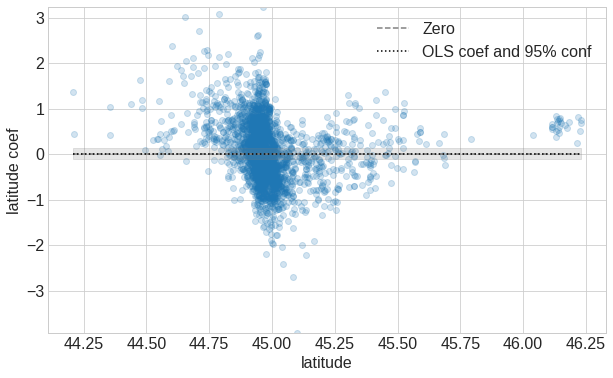

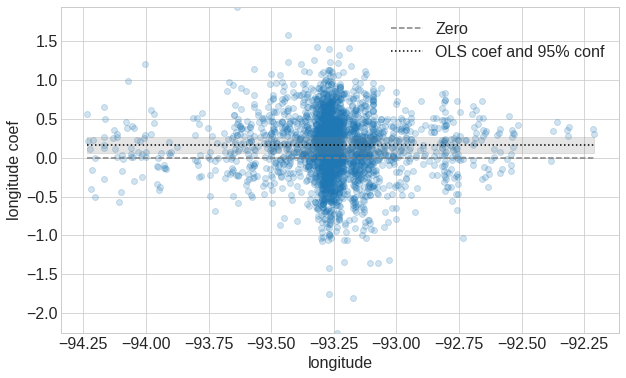

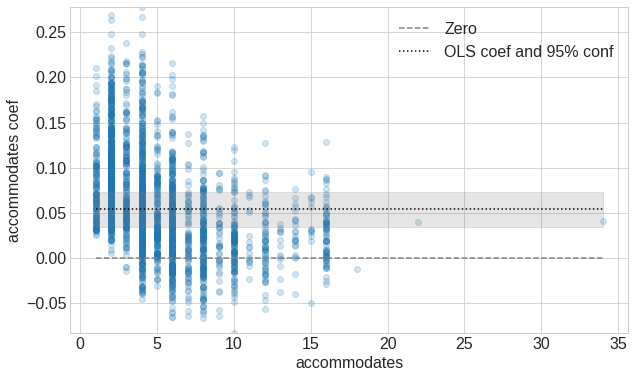

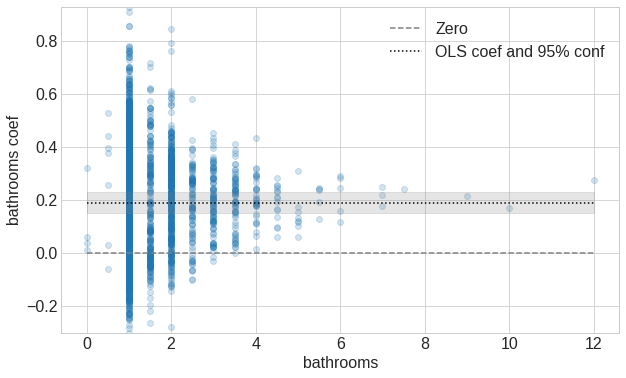

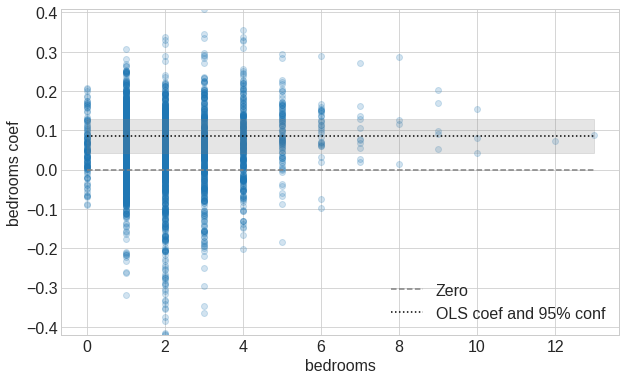

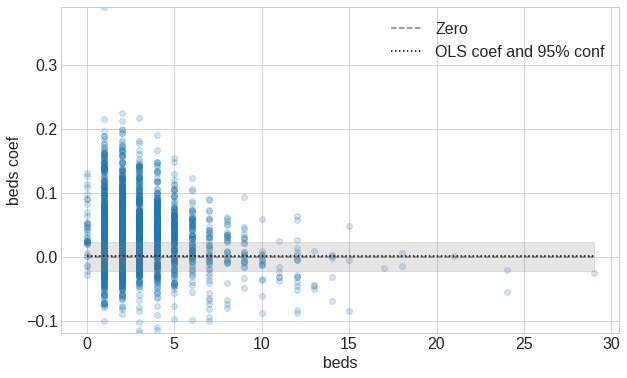

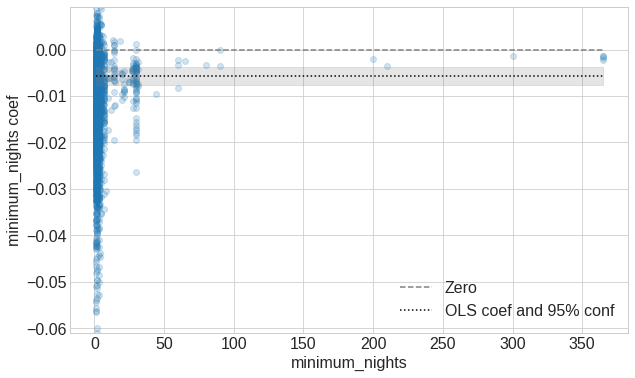

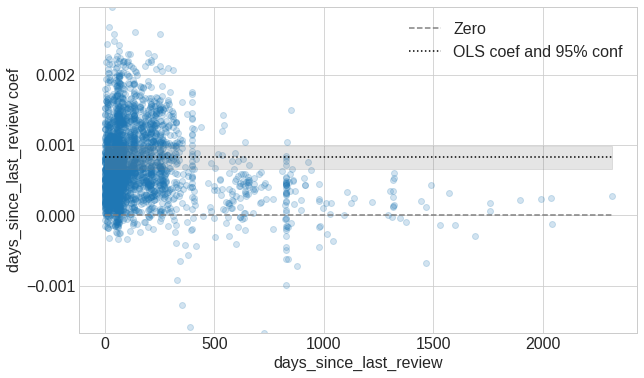

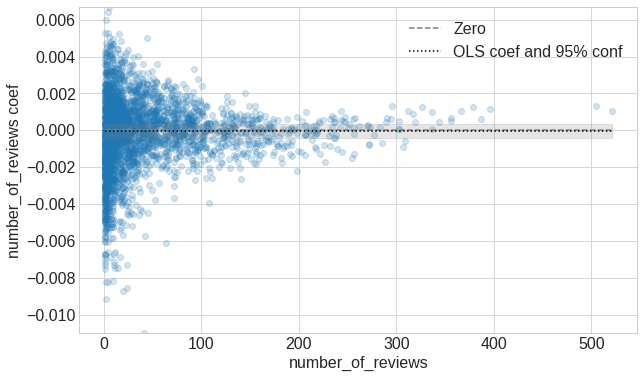

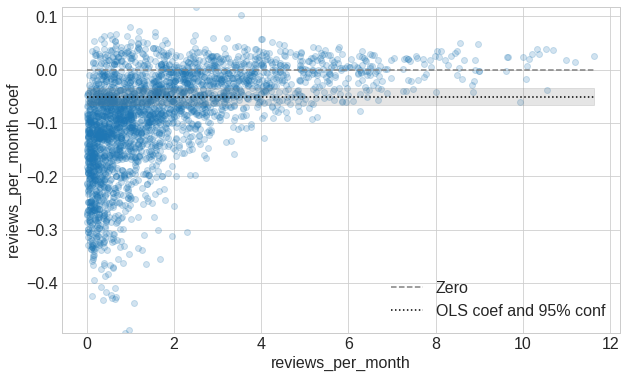

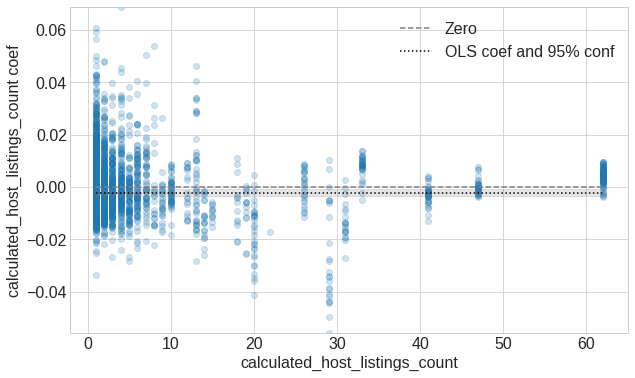

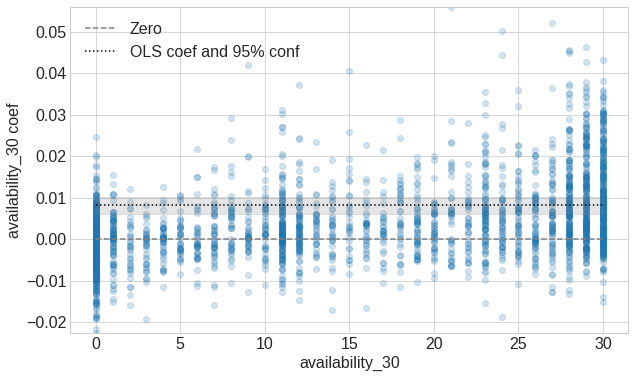

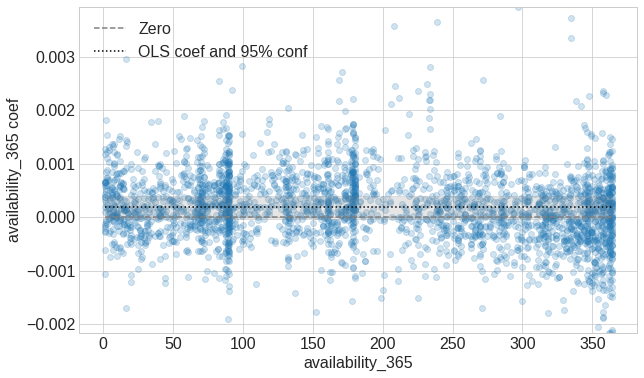

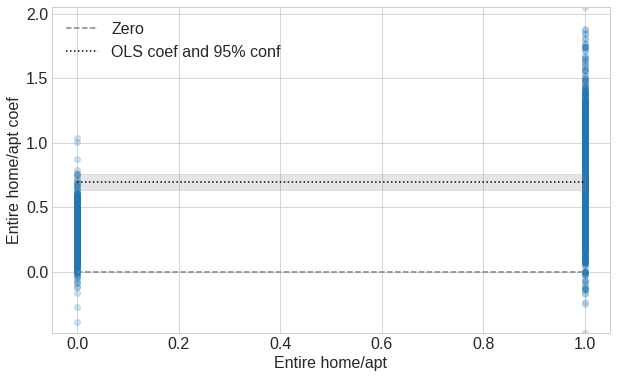

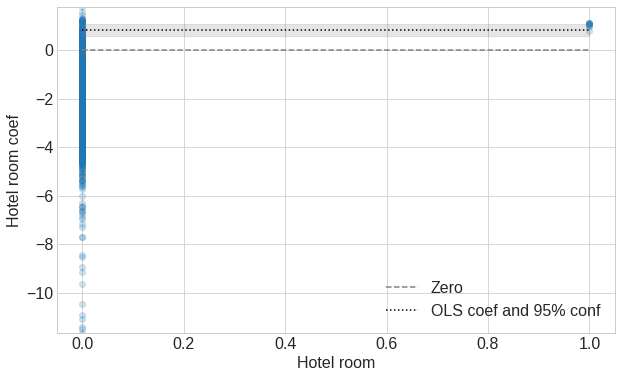

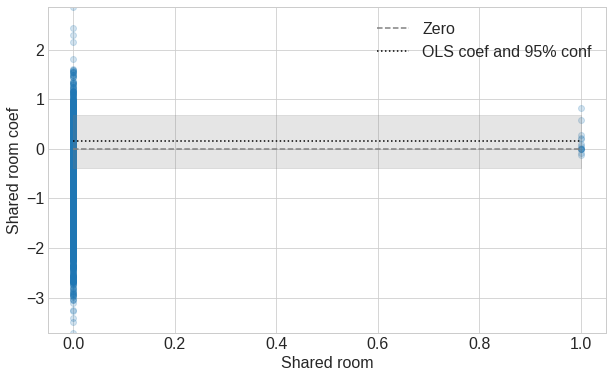

In [77]:
import plotcoefs

plotcoefs.plot_coefs_by_self(features, dnn_coefs, results)

## Location gradients
* Location coefficients norm is a measure of effect of location on price

In [78]:
location_sensitivity = dnn_coefs[['latitude', 'longitude']].apply(
    np.linalg.norm, axis=1)

mapairbnb.plot(data, features, color_by=location_sensitivity,
               color_title='location sensitivity', hover=False)

* We see listings that are very sensitive mixed among ones that are not. 
* So location sensitivity must be driven by features other than location itself.

### location valuations by location gradient
* Focus on listings with high location sensitivity

In [79]:
location_sensitivity.name = 'loc_sens'
with_loc_sens = features.join(location_sensitivity).sort_values(by='loc_sens')

# Pick a few listings from the high end of the sensitivity sort
# and use them to get a location valuation plot
for p in np.linspace(0.9, 1, 5):

    i = int(p * (len(features)-1))

    fixed_app = with_loc_sens.iloc[i, :].drop('loc_sens')
    print(with_loc_sens.iloc[i, :].drop(['latitude', 'longitude']).to_dict())

    location_only = fixcolumns.fix(data=features,
                                   fix_columns=features.columns[2:],
                                   fix_on=fixed_app.values)

    location_predicted = model.predict(
        scaler.transform(location_only)).flatten()

    mapairbnb.plot(data, features, color_by=np.exp(location_predicted),
                   color_title='Predicted price', hover=False, zoom=8).show()

{'accommodates': 6.0, 'bathrooms': 2.0, 'bedrooms': 2.0, 'beds': 3.0, 'minimum_nights': 1.0, 'days_since_last_review': 106.0, 'number_of_reviews': 2.0, 'reviews_per_month': 0.45, 'calculated_host_listings_count': 29.0, 'availability_30': 30.0, 'availability_365': 234.0, 'Entire home/apt': 1.0, 'Hotel room': 0.0, 'Shared room': 0.0, 'loc_sens': 1.1680079698562622}


{'accommodates': 4.0, 'bathrooms': 1.0, 'bedrooms': 2.0, 'beds': 2.0, 'minimum_nights': 1.0, 'days_since_last_review': 9.0, 'number_of_reviews': 123.0, 'reviews_per_month': 2.44, 'calculated_host_listings_count': 1.0, 'availability_30': 29.0, 'availability_365': 296.0, 'Entire home/apt': 1.0, 'Hotel room': 0.0, 'Shared room': 0.0, 'loc_sens': 1.2516168355941772}


{'accommodates': 4.0, 'bathrooms': 1.0, 'bedrooms': 1.0, 'beds': 1.0, 'minimum_nights': 2.0, 'days_since_last_review': 73.0, 'number_of_reviews': 39.0, 'reviews_per_month': 1.46, 'calculated_host_listings_count': 1.0, 'availability_30': 28.0, 'availability_365': 168.0, 'Entire home/apt': 1.0, 'Hotel room': 0.0, 'Shared room': 0.0, 'loc_sens': 1.4316877126693726}


{'accommodates': 2.0, 'bathrooms': 1.0, 'bedrooms': 1.0, 'beds': 2.0, 'minimum_nights': 1.0, 'days_since_last_review': 186.0, 'number_of_reviews': 9.0, 'reviews_per_month': 0.38, 'calculated_host_listings_count': 1.0, 'availability_30': 30.0, 'availability_365': 89.0, 'Entire home/apt': 1.0, 'Hotel room': 0.0, 'Shared room': 0.0, 'loc_sens': 1.7044923305511475}


{'accommodates': 6.0, 'bathrooms': 1.0, 'bedrooms': 2.0, 'beds': 3.0, 'minimum_nights': 2.0, 'days_since_last_review': 200.0, 'number_of_reviews': 3.0, 'reviews_per_month': 0.38, 'calculated_host_listings_count': 20.0, 'availability_30': 28.0, 'availability_365': 363.0, 'Entire home/apt': 1.0, 'Hotel room': 0.0, 'Shared room': 0.0, 'loc_sens': 3.936304807662964}


* Maps for high location sensitivity listings are generally better. 
* Can we do any better still?

# A vertically partitioned network
* Location should not interact with other features
* Build a model where location is not allowed to interact with anything else
 

In [80]:
%%writefile loc_dnn.py
import tensorflow.keras as keras
from tf_r2 import R_squared


def build_model(
        input_shape,
        dropout=0.2,
        activation='relu',
        width=128,
        n_hidden=2,
        optimizer=keras.optimizers.SGD(0.05)):

    inputs = keras.Input(shape=input_shape)

    # Separate the location on the first two indexes from the rest of
    # the inputs.
    loc = inputs[:, :2]
    for i in range(n_hidden):
        loc = keras.layers.Dense(width, activation=activation)(loc)
        loc = keras.layers.Dropout(dropout)(loc)
    loc = keras.layers.Dense(1)(loc)

    rest = inputs[:, 2:]
    for i in range(n_hidden):
        rest = keras.layers.Dense(width, activation=activation)(rest)
        rest = keras.layers.Dropout(dropout)(rest)
    rest = keras.layers.Dense(1)(rest)

    # Sum the two outputs so that they both have log price units.
    output = loc + rest

    loc_model = keras.Model(inputs=inputs, outputs=loc)
    full_model = keras.Model(inputs=inputs, outputs=output)

    full_model.compile(loss='mse',
                       optimizer=optimizer, 
                       metrics=[R_squared])

    return full_model, loc_model


Overwriting loc_dnn.py


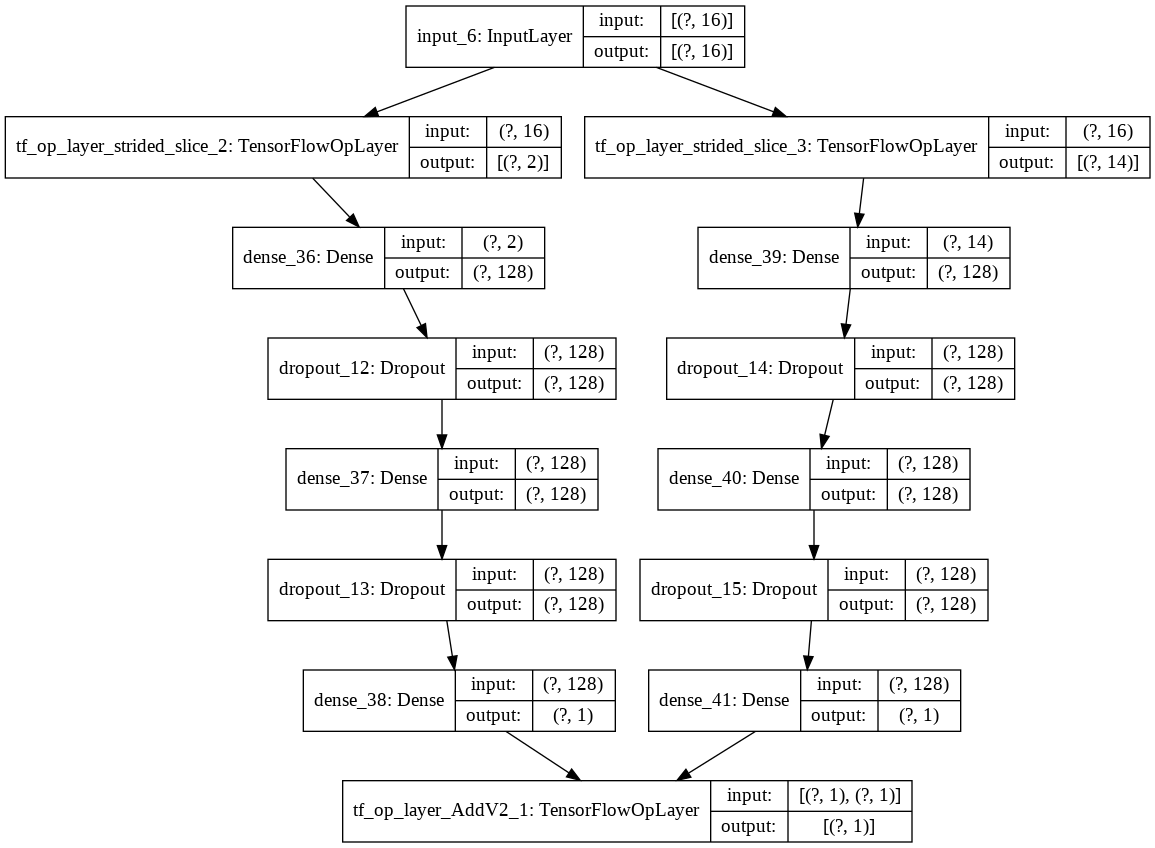

In [81]:
import loc_dnn
import tensorflow.keras as keras
import tensorflow as tf

tf.random.set_seed(42)

model_all, loc_model = loc_dnn.build_model(X_train.shape[1:])

keras.utils.plot_model(model_all, show_shapes=True)

In [82]:
history = train_dnn.train(model_all, X_train_scaled, y_train, 
                          X_test_scaled, y_test)

Epoch 1/1000
67/67 [==============================] - 0s 4ms/step - loss: 1.2956 - R_squared: -0.6646 - val_loss: 0.3054 - val_R_squared: 0.5298
Epoch 2/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.4084 - R_squared: 0.4376 - val_loss: 0.2907 - val_R_squared: 0.5488
Epoch 3/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.3581 - R_squared: 0.5025 - val_loss: 0.2710 - val_R_squared: 0.5854
Epoch 4/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.3505 - R_squared: 0.5080 - val_loss: 0.2927 - val_R_squared: 0.5546
Epoch 5/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.3228 - R_squared: 0.5676 - val_loss: 0.2613 - val_R_squared: 0.6032
Epoch 6/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.3115 - R_squared: 0.5774 - val_loss: 0.2464 - val_R_squared: 0.6246
Epoch 7/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.3110 - R_squared: 0.5686 - val_loss: 0.2518 - val_R_squared

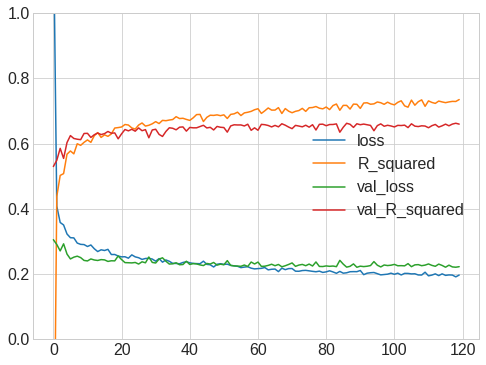

In [83]:
pd.DataFrame(history.history).plot(ylim=(0, 1), grid=True, figsize=(8, 6))

## Performance

In [84]:
loc_DNN_r2 = dict(
    Train=tf_r2.R_squared(
        y_train, model_all.predict(X_train_scaled).flatten()).numpy(),
    Test=tf_r2.R_squared(
        y_test, model_all.predict(X_test_scaled).flatten()).numpy())

pd.DataFrame([OLS_r2, DNN_r2, loc_DNN_r2], index=['OLS R2', 'DNN R2',
                                                  'loc DNN R2'])

Train      Test
OLS R2      0.629655  0.597670
DNN R2      0.770162  0.672420
loc DNN R2  0.764075  0.674639

Nice improvement!

## One last time, location!

In [85]:
location_predicted = loc_model.predict(scaler.transform(features)).flatten()

mapairbnb.plot(data, features, color_by=location_predicted,
               color_title='Diff log price', hover=False, zoom=8)

Finally, it's correct!

# Take aways
* The three APIs: go for Functional
* Estimating value: be wary of reverse causality
* Gradients: they're easy to compute and illuminating to look at
